In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus']=False

# sql 함수 사용
from pyspark.sql.functions import when, udf, col, regexp_replace
# sql 타입변경
from pyspark.sql.types import DoubleType,IntegerType, StringType
import pyspark.sql.functions as F

In [2]:
sc = SparkContext('local') # 'spark://ip:7070'
sqlCtx = SQLContext( sc )

In [3]:
titanic = sqlCtx.read.csv(r'c:\data\titanic1.csv',header=True,inferSchema=True)
titanic.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|
|       0|     1|54.0|    0|    0|51.8625|          0|    1|      0.0|           0.0|          0.0|


### 1. age 컬럼 null 의 갯수를 구하시요


In [4]:
titanic_age = titanic.select('age').toPandas()

In [5]:
titanic_age[titanic_age.isnull()].count()

age    0
dtype: int64

In [6]:
titanic.where("Age is null").count()

0

### 2. age null 평균값을 채우시요.

In [7]:
age_avg= titanic.agg(F.mean('age')).collect()[0]['avg(age)']
titanic.select('age').fillna(age_avg).show()

+----+
| age|
+----+
|22.0|
|38.0|
|26.0|
|35.0|
|35.0|
|33.0|
|54.0|
| 2.0|
|27.0|
|14.0|
| 4.0|
|58.0|
|20.0|
|39.0|
|14.0|
|55.0|
| 2.0|
|33.0|
|31.0|
|36.0|
+----+
only showing top 20 rows



In [24]:
# titanic.fillna({'Age':titanic.agg(F.mean('Age')).collect()[0]['avg(Age)']}).show()
titanic.select('Age').fillna(titanic.agg(F.mean('Age')).collect()[0]['avg(Age)']).show()

+----+
| Age|
+----+
|22.0|
|38.0|
|26.0|
|35.0|
|35.0|
|33.0|
|54.0|
| 2.0|
|27.0|
|14.0|
| 4.0|
|58.0|
|20.0|
|39.0|
|14.0|
|55.0|
| 2.0|
|33.0|
|31.0|
|36.0|
+----+
only showing top 20 rows



### 3. 등급별(pclass) 평균 생존을 구하시요


In [8]:
titanic.groupBy('Pclass').agg(F.mean('Survived').alias('등급별 평균 생존')).show()

+------+-------------------+
|Pclass|   등급별 평균 생존|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+



### 4. 혼자탑승(alone)한 인원의 평균 생존을 구하시요

In [9]:
titanic.where(" Alone == 1 ").agg(F.mean('Survived').alias('혼자 탑승 인원의 평균 생존')).show()

+--------------------------+
|혼자 탑승 인원의 평균 생존|
+--------------------------+
|       0.30353817504655495|
+--------------------------+



### 5. 나이분류 컬럼을 추가하시요: 1 ~ 15(미성년자), 15 ~ 25(청년), 25 ~ 35(중년), 35 ~ 60(장년), 60 ~ (노년)  

In [10]:
titanic_ageCla = titanic.withColumn('age_Cla',
                when(titanic['Age']<15, '미성년자').\
                when(titanic['Age']<25, '청년').\
                when(titanic['Age']<35, '중년').\
                when(titanic['Age']<60, '장년').\
                otherwise('노년')  
                 )

In [11]:
titanic_ageCla.toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,age_Cla
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,청년
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,장년
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,중년
3,1,1,35.0,1,0,53.1000,1,0,1.0,0.0,2.0,장년
4,0,3,35.0,0,0,8.0500,0,1,0.0,0.0,0.0,장년
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0.0,0.0,4.0,중년
887,1,1,19.0,0,0,30.0000,0,1,1.0,0.0,1.0,청년
888,0,3,22.0,1,2,23.4500,3,0,1.0,0.0,1.0,청년
889,1,1,26.0,0,0,30.0000,0,1,0.0,1.0,0.0,중년


### 6. 나이분류를 파이차트로 표시하시요

In [12]:
titanic_ageCla_pd = titanic_ageCla.select('age_Cla').toPandas()

In [13]:
titanic_ageCla_pd[titanic_ageCla_pd['age_Cla'] == '미성년자'].count()[0]

82

In [14]:
labels = ['미성년자','청년','중년','장년','노년']

ratio = [
    titanic_ageCla_pd[titanic_ageCla_pd['age_Cla'] == '미성년자'].count()[0],
    titanic_ageCla_pd[titanic_ageCla_pd['age_Cla'] == '청년'].count()[0],
    titanic_ageCla_pd[titanic_ageCla_pd['age_Cla'] == '중년'].count()[0],
    titanic_ageCla_pd[titanic_ageCla_pd['age_Cla'] == '장년'].count()[0],
    titanic_ageCla_pd[titanic_ageCla_pd['age_Cla'] == '노년'].count()[0]
]

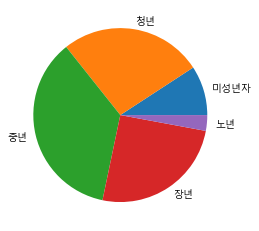

In [15]:
plt.pie(ratio,labels=labels)
plt.show()

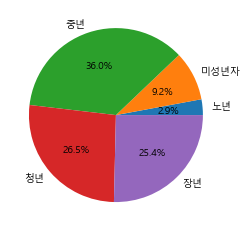

In [19]:
# 6 나이분류를 파이차트로 표시하시요
ageDF = titanic_ageCla.groupBy('age_Cla').count().toPandas()
ageDF
plt.pie(ageDF['count'],labels=ageDF['age_Cla'],autopct='%1.1f%%')
plt.show()